<a href="https://colab.research.google.com/github/brlivsky/masking-detection/blob/main/CancerGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Initializing the Cancer Dataset class

In [ ]:
# Imports
import os, torch
from torch import nn
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm.auto import tqdm
from natsort import natsorted
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision import transforms
from torchvision import datasets
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt

 
# Define your own class LoadFromFolder
class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
         
        # Set the loading directory
        self.main_dir = main_dir
        self.transform = transform
         
        # List all images in folder and count them
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 128, 128)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

###Generator

In [ ]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (augmented images are 128 x 128 = 16384 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=16384, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()

        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    
    # Needed for grading
    def get_gen(self):
        '''
        Returns:
            the sequential model
        '''
        return self.gen

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    # NOTE: To use this on GPU with device='cuda', make sure to pass the device 
    # argument to the function you use to generate the noise.
    return torch.randn(n_samples, z_dim, device=device)


In [ ]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2)      
    )

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (Mammographic images are 128 x 128 = 16384 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=16384, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # You want to transform the final output into a single value,
            # so add one more linear map.
            nn.Linear(hidden_dim,1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    
    # Needed for grading
    def get_disc(self):
        '''
        Returns:
            the sequential model
        '''
        return self.disc

In [ ]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 10
display_step = 500
batch_size = 128
lr = 0.00001

transform = transforms.Compose(
        [transforms.Resize([128, 128]),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()])

# Load dataset as tensors
dataloader = DataLoader(
    # root = location of the dataset
    ImageFolder(root="/content/drive/My Drive/dataset", transform=transform),
    batch_size=batch_size,
    shuffle=True)

### DO NOT EDIT ###
device = 'cuda'

In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    noise = get_noise(num_images, z_dim, device=device)
    fake = gen(noise)
    fake_pred = disc(fake.detach())
    fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))
    
    real_pred = disc(real)
    real_loss = criterion(real_pred, torch.ones_like(real_pred))
    disc_loss = (fake_loss + real_loss)/2
    return disc_loss

In [ ]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #       1) Create noise vectors and generate a batch of fake images. 
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real

    noise = get_noise(num_images, z_dim, device=device)
    fake = gen(noise)
    pred = disc(fake)
    gen_loss = criterion(pred, torch.ones_like(pred))
    return gen_loss

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 500: Generator loss: 2.493434983611107, discriminator loss: 0.2400092590451241


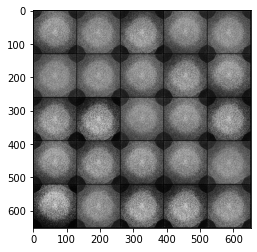

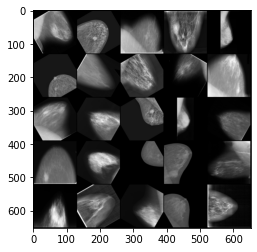

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 1000: Generator loss: 2.364376154661179, discriminator loss: 0.2654423390328886


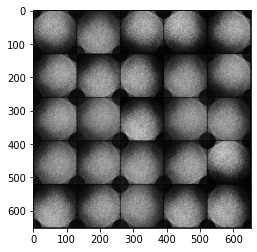

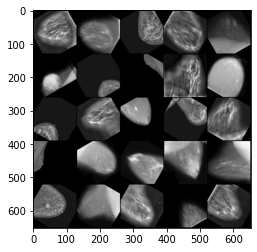

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 1500: Generator loss: 2.0545242362022407, discriminator loss: 0.2560424593985079


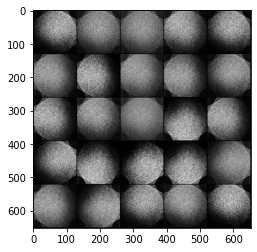

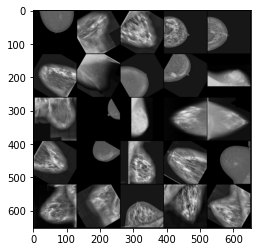

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 2000: Generator loss: 2.345603990554809, discriminator loss: 0.2192476944327352


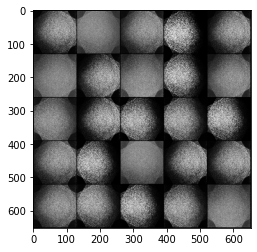

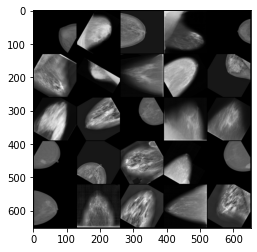

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 2500: Generator loss: 2.9978082861900344, discriminator loss: 0.09190518402308233


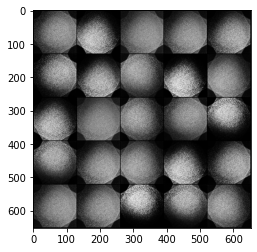

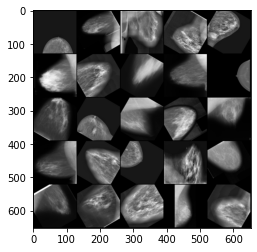

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 3000: Generator loss: 2.558719343185423, discriminator loss: 0.13552525921165942


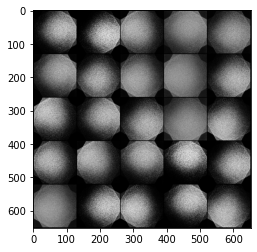

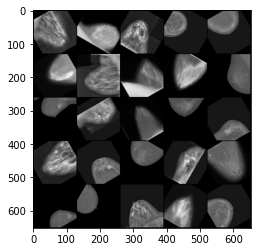

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 3500: Generator loss: 2.543632804155349, discriminator loss: 0.14174847483634956


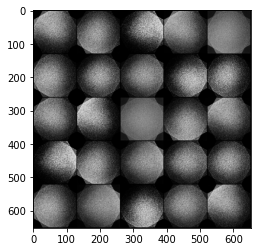

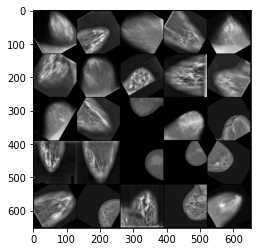

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.895795556545257, discriminator loss: 0.11041384837031365


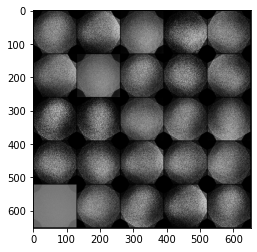

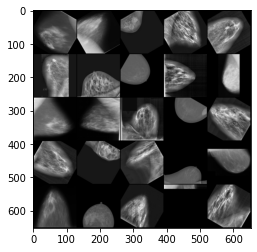

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 4500: Generator loss: 3.1564316172599782, discriminator loss: 0.10044856508076197


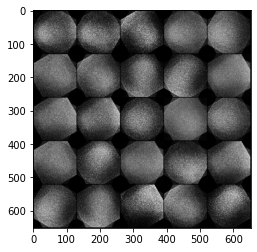

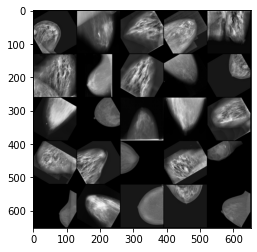

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 5000: Generator loss: 3.169661605834959, discriminator loss: 0.08497259051352739


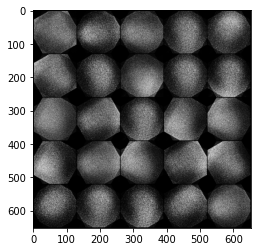

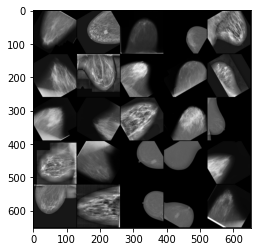

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 5500: Generator loss: 3.0159723863601697, discriminator loss: 0.09327285140007734


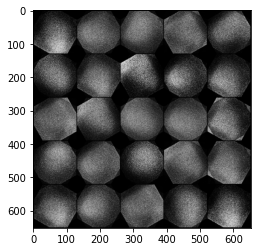

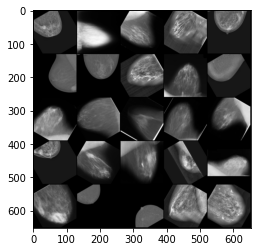

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 6000: Generator loss: 2.795263185501102, discriminator loss: 0.10643440361320976


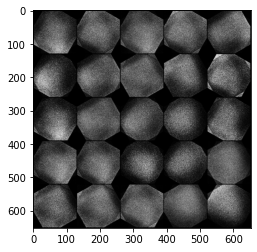

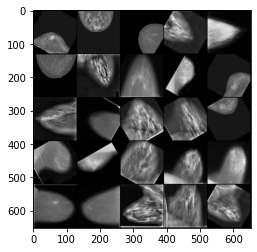

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 6500: Generator loss: 2.6612781882286067, discriminator loss: 0.12061307975649845


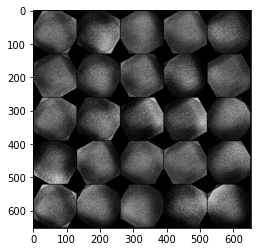

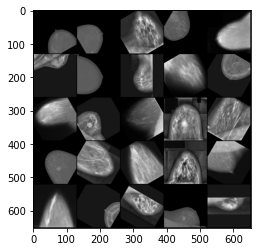

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 7000: Generator loss: 2.7822836532592743, discriminator loss: 0.09722890876233578


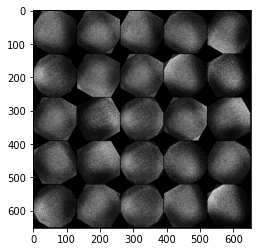

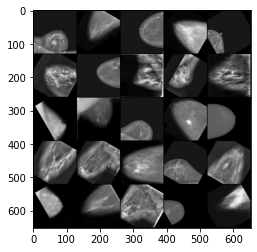

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 7500: Generator loss: 2.636718822717662, discriminator loss: 0.11545343807339666


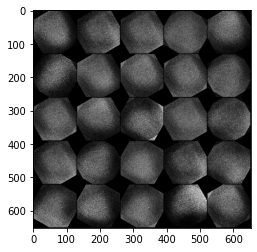

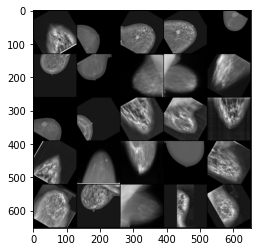

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 8000: Generator loss: 2.7878718187808973, discriminator loss: 0.10006476921588188


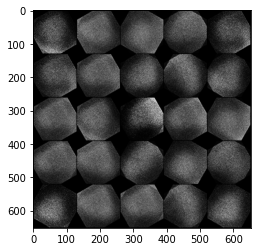

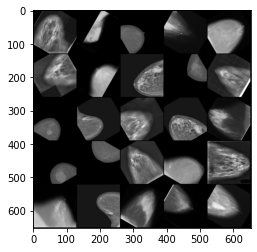

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 8500: Generator loss: 2.7730372700691217, discriminator loss: 0.10430984303355215


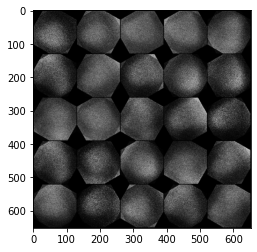

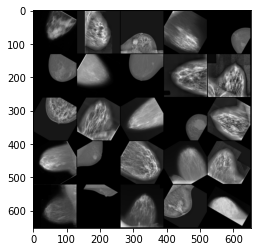

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 9000: Generator loss: 2.84414563846588, discriminator loss: 0.09724329719692475


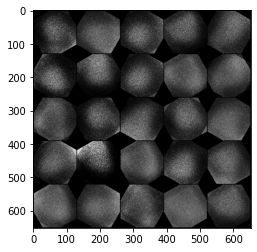

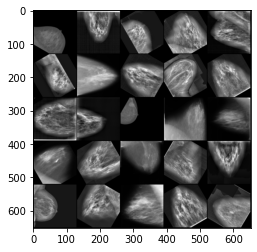

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 9500: Generator loss: 2.799832218170166, discriminator loss: 0.10077893970906729


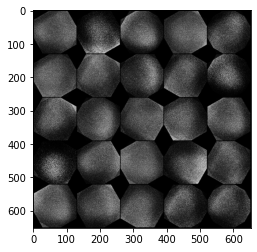

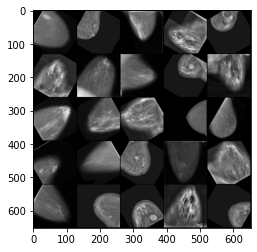

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 10000: Generator loss: 2.9280016684532164, discriminator loss: 0.09147679531574254


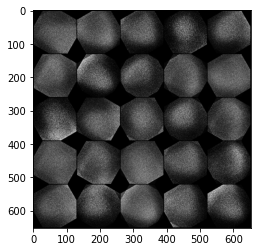

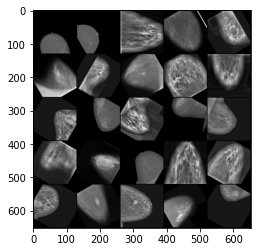

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 10500: Generator loss: 2.958583341121674, discriminator loss: 0.08991630914807319


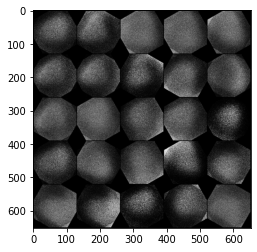

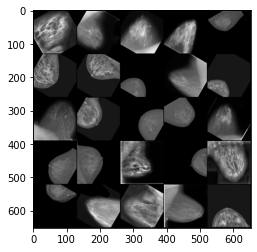

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 11000: Generator loss: 3.0127819061279286, discriminator loss: 0.08767774049937731


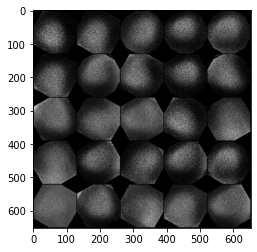

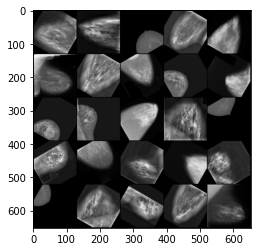

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 11500: Generator loss: 3.0901147832870466, discriminator loss: 0.08416199297457932


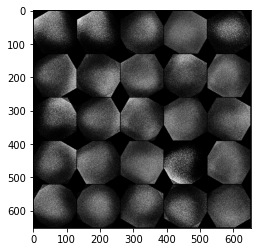

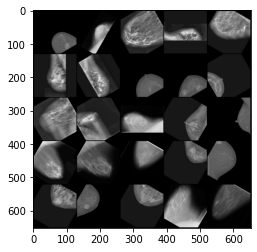

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 12000: Generator loss: 3.011121584415436, discriminator loss: 0.09225692591071136


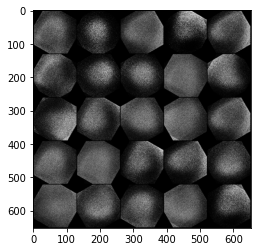

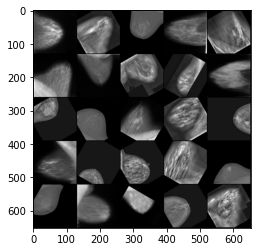

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 12500: Generator loss: 3.048010552406313, discriminator loss: 0.09312936329841612


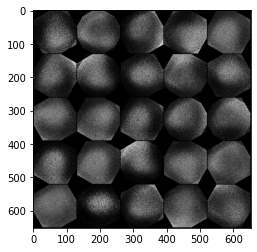

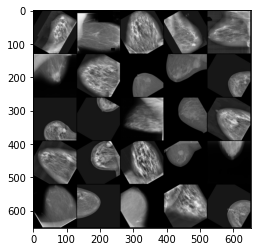

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 13000: Generator loss: 3.1116955122947707, discriminator loss: 0.09334014026820657


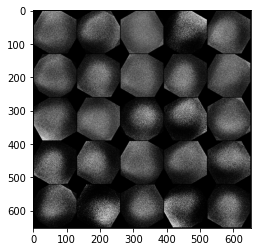

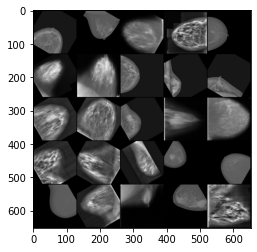

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 13500: Generator loss: 3.187395867347719, discriminator loss: 0.08656314864009622


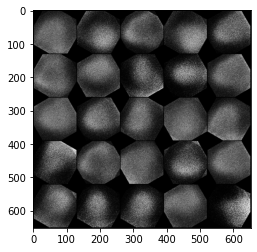

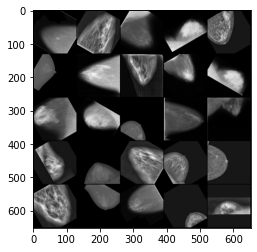

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 14000: Generator loss: 3.157860559940343, discriminator loss: 0.09096848400682202


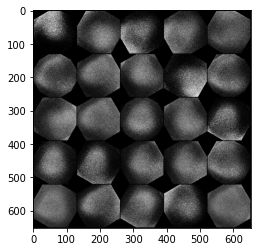

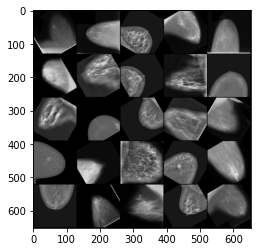

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 14500: Generator loss: 3.2136978263854967, discriminator loss: 0.09231890391558403


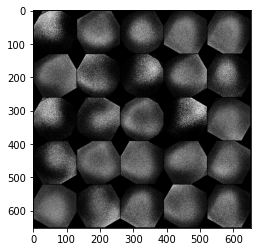

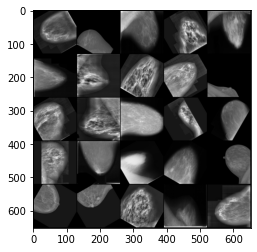

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 15000: Generator loss: 3.1826704847812666, discriminator loss: 0.09457727664709095


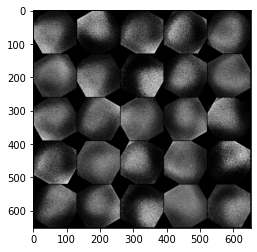

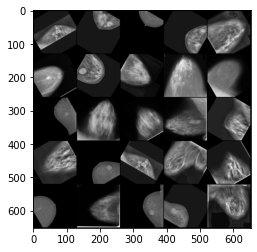

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 15500: Generator loss: 3.2268311195373545, discriminator loss: 0.09783829400688414


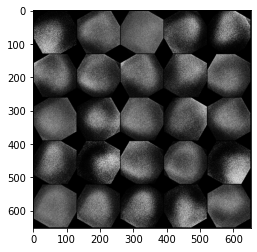

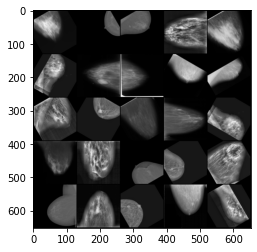

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 16000: Generator loss: 3.163804473876955, discriminator loss: 0.1070195043236017


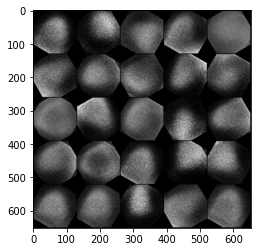

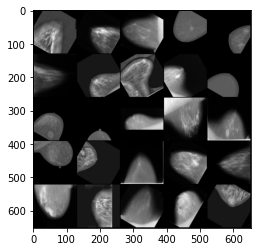

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 16500: Generator loss: 3.258090146541596, discriminator loss: 0.10035391291975977


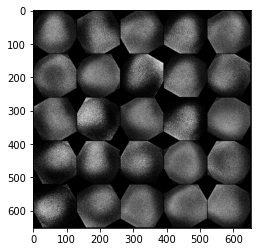

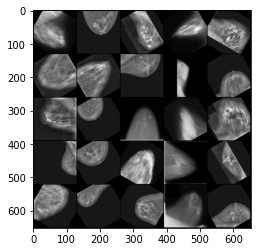

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 17000: Generator loss: 3.266415798425672, discriminator loss: 0.10719477048516289


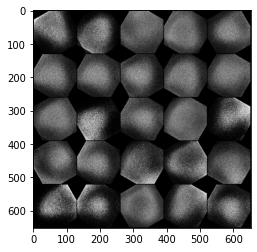

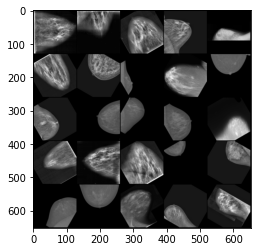

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 17500: Generator loss: 3.349800999164581, discriminator loss: 0.10901314088702205


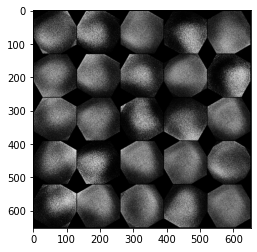

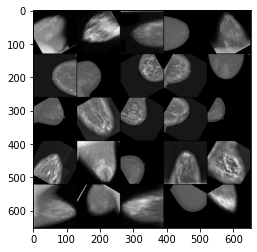

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 18000: Generator loss: 3.3730504565238975, discriminator loss: 0.10366169290244583


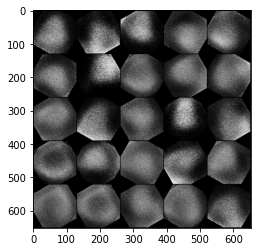

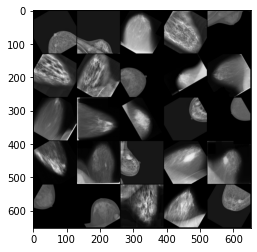

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 18500: Generator loss: 3.3997367296218886, discriminator loss: 0.11060123030841339


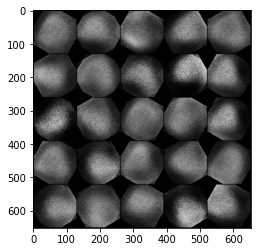

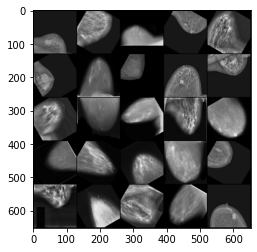

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 19000: Generator loss: 3.305099501371383, discriminator loss: 0.12909796483814726


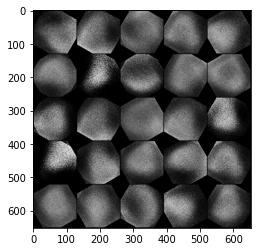

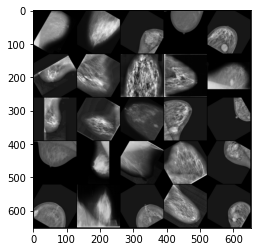

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 19500: Generator loss: 3.24420496559143, discriminator loss: 0.12388004928827295


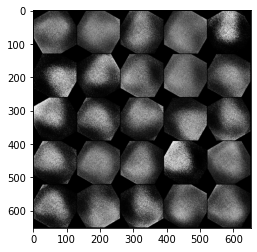

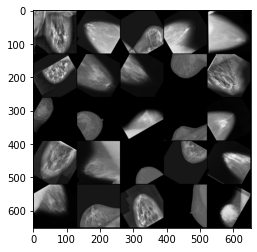

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 20000: Generator loss: 3.2841233558654794, discriminator loss: 0.1252142032086849


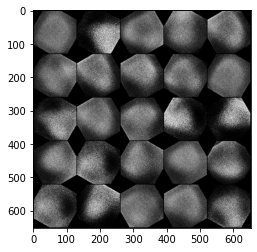

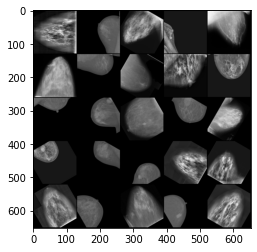

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 20500: Generator loss: 3.311755094528199, discriminator loss: 0.12282150077819834


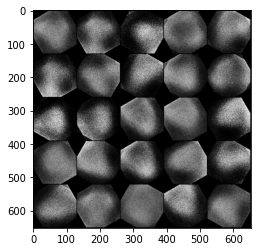

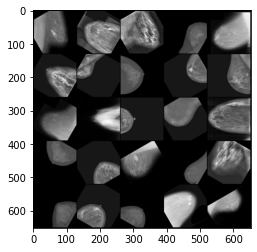

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 21000: Generator loss: 3.3344097876548773, discriminator loss: 0.1270249718129634


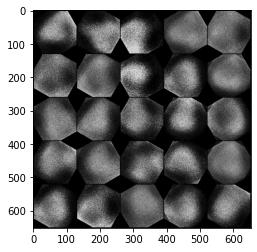

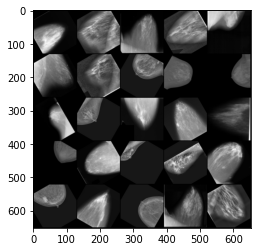

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 21500: Generator loss: 3.3311365635395025, discriminator loss: 0.13562221246212722


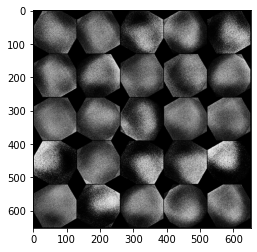

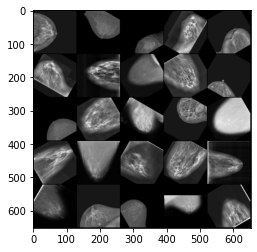

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 22000: Generator loss: 3.3704004974365245, discriminator loss: 0.12570350271463382


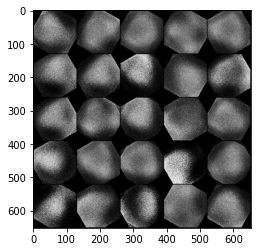

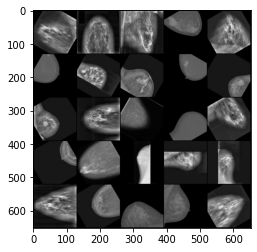

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 22500: Generator loss: 3.373272798538207, discriminator loss: 0.13146683315932753


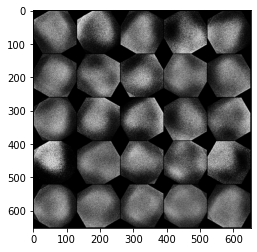

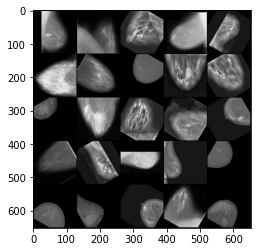

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 23000: Generator loss: 3.289873243331909, discriminator loss: 0.1399187481403349


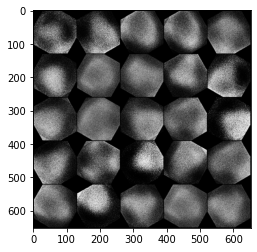

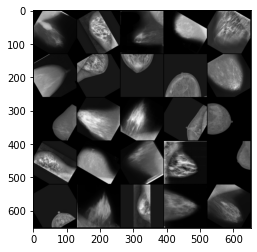

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 23500: Generator loss: 3.315953781604765, discriminator loss: 0.1398606111556294


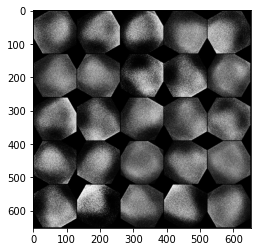

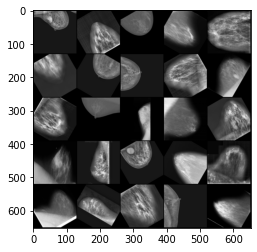

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 24000: Generator loss: 3.304918903350829, discriminator loss: 0.14182205972075473


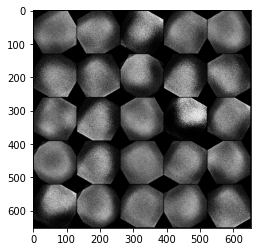

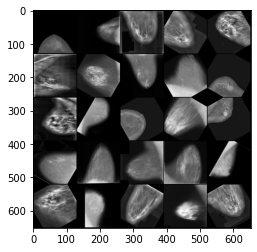

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 24500: Generator loss: 3.4969041483402266, discriminator loss: 0.1321557192504406


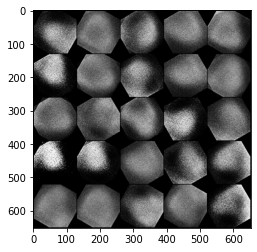

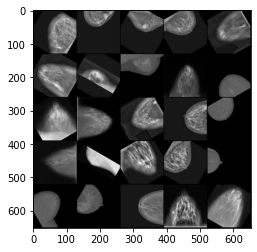

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 25000: Generator loss: 3.457952682018278, discriminator loss: 0.12758967997133733


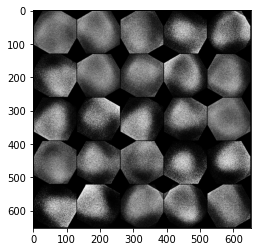

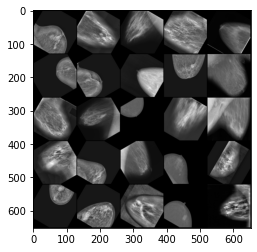

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 25500: Generator loss: 3.475751660823818, discriminator loss: 0.1288695983290674


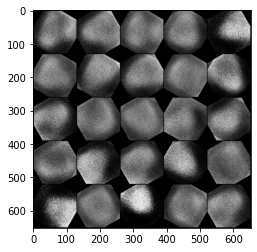

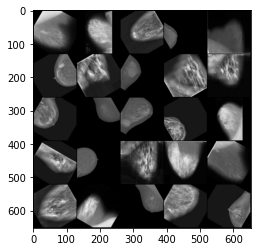

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 26000: Generator loss: 3.349071449279786, discriminator loss: 0.13727195063233386


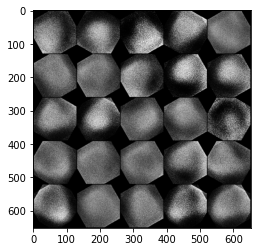

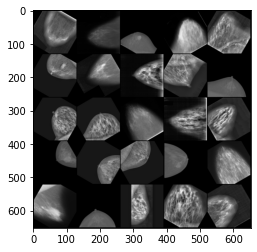

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 26500: Generator loss: 3.3334791779518143, discriminator loss: 0.13728586225211625


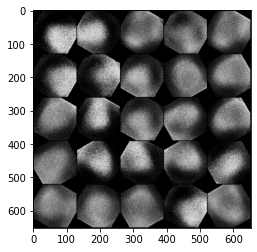

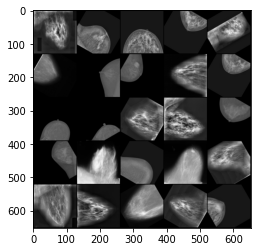

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 27000: Generator loss: 3.364663507699967, discriminator loss: 0.14908892570435991


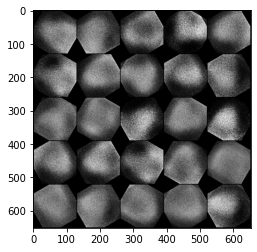

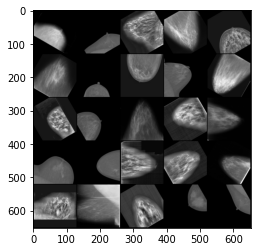

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

Step 27500: Generator loss: 3.4189639329910264, discriminator loss: 0.13875265035033227


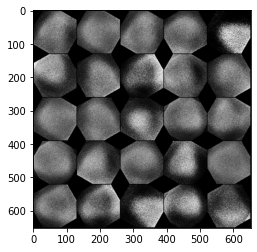

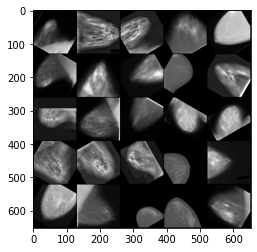

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real) #128

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        ### Update generator ###
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
